## N차 과제 - Time Series Analysis_주가예측

- 주제: 시계열 모델을 주가 데이터에 대한 시계열 예측 및 분석
- 데이터: 주식 데이터(크롤링 or 라이브러리로 데이터 불러오기)
- 사용 라이브러리: yfinance, datareader, statsmodels, matplotlib etc.

In [2]:
pip install yfinance

  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/51/31/72b8f5aa9ed9c4a6afd09c0bab491862ba5837facf7d81e1ed51a555ae8e/yfinance-0.2.44-py2.py3-none-any.whl.metadata
  Obtaining dependency information for multitasking>=0.0.7 from https://files.pythonhosted.org/packages/3e/8a/bb3160e76e844db9e69a413f055818969c8acade64e1a9ac5ce9dfdcf6c1/multitasking-0.0.11-py3-none-any.whl.metadata
  Obtaining dependency information for frozendict>=2.3.4 from https://files.pythonhosted.org/packages/86/20/2a2514d0b504e773078c38d664108bc8ae9056f85ea57c6fff86eee07331/frozendict-2.4.5-py311-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 36.0 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for html5lib>=1.1 from https://files.pythonhosted.org/packages/6c/dd/a834df6482147d48e225a49515aabc28974

In [3]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


### 1. EDA 및 전처리

1.1 분석을 위해 사용할 특정 주식(1개)의 데이터를 불러오거나 크롤링하여 가져오세요(**최소 3년 이상의 데이터 추출 권고**).

In [7]:
ticker = 'AAPL'
df = yf.download(ticker, start='2019-01-01', end='2022-12-31')
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,37.750092,148158800
2019-01-03,35.994999,36.430000,35.500000,35.547501,33.989902,365248800
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.440907,234428400
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.362015,219111200
2019-01-08,37.389999,37.955002,37.130001,37.687500,36.036133,164101200
...,...,...,...,...,...,...
2022-12-23,130.919998,132.419998,129.639999,131.860001,130.631348,63814900
2022-12-27,131.380005,131.410004,128.720001,130.029999,128.818405,69007800
2022-12-28,129.669998,131.029999,125.870003,126.040001,124.865585,85438400


1.2 결측치가 있는지 확인하고 있다면 제거해주세요.

In [8]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

1.3 일자를 인덱스로 설정하고 시간 순서대로 정렬하세요.

In [11]:
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,37.750092,148158800
2019-01-03,35.994999,36.430000,35.500000,35.547501,33.989902,365248800
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.440907,234428400
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.362015,219111200
2019-01-08,37.389999,37.955002,37.130001,37.687500,36.036133,164101200
...,...,...,...,...,...,...
2022-12-23,130.919998,132.419998,129.639999,131.860001,130.631348,63814900
2022-12-27,131.380005,131.410004,128.720001,130.029999,128.818405,69007800
2022-12-28,129.669998,131.029999,125.870003,126.040001,124.865585,85438400


1.4 수정종가(adj close)와 거래량(volume)을 시각화하세요.

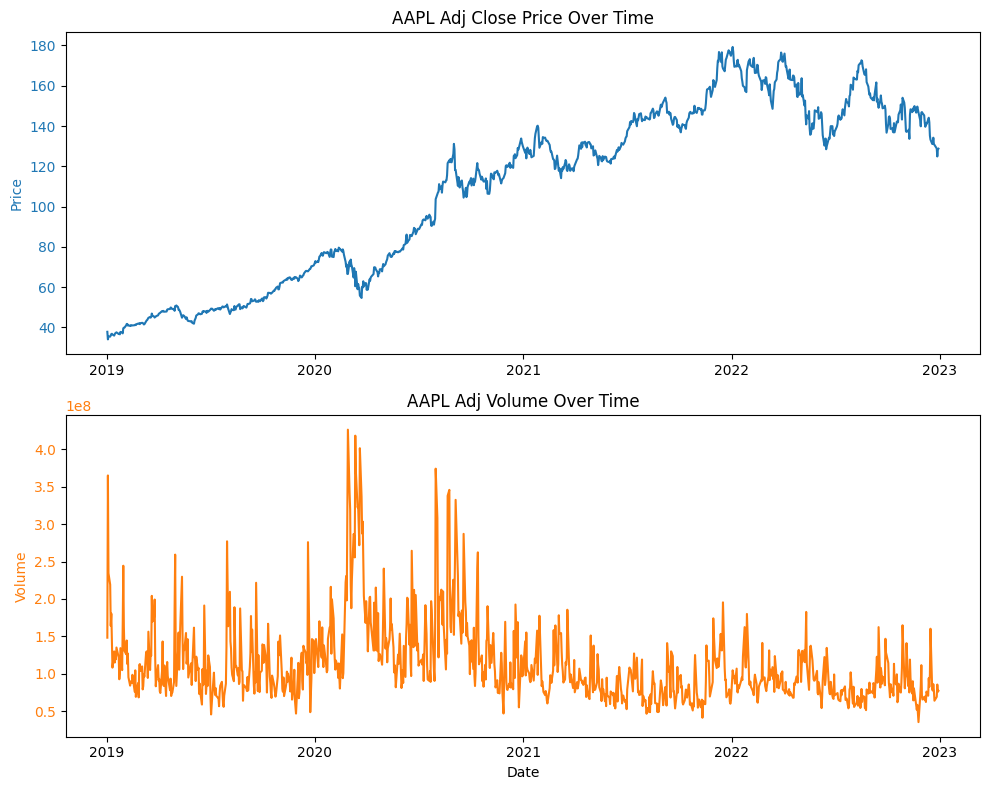

In [33]:
import matplotlib.dates as mdates
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# 1. 수정 종가 (adj close)
ax1.plot(df.index, df['Adj Close'], color='tab:blue', label='Adj Close')
ax1.set_ylabel('Price', color='tab:blue')
ax1.set_title(f'{ticker} Adj Close Price Over Time')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 2. 거래량 (volume)
ax2.plot(df.index, df['Volume'], color='tab:orange', label='Volume')
ax2.set_ylabel('Volume', color='tab:orange')
ax2.set_title(f'{ticker} Adj Volume Over Time')
ax2.tick_params(axis='y', labelcolor='tab:orange')

ax2.set_xlabel('Date')
years = mdates.YearLocator()  # 매년 간격
years_fmt = mdates.DateFormatter('%Y')  # 연도만 표시

ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(years_fmt)

ax2.xaxis.set_major_locator(years)
ax2.xaxis.set_major_formatter(years_fmt)

fig.tight_layout()

plt.show()

1.5 위 시각화 과정을 통해 알 수 있는 내용에 대해 작성하세요.

수정 종가 상승, 거래량 하락

### 2. 추세 및 정상성 검정

2.1 시계열 데이터의 정상성을 검증하도록 하겠습니다. 시계열 데이터 말하는 정상성(stationarity)이 무엇인지 왜 해야 하며 비정상성의 해결 방법에는 무엇이 있는지 작성하세요.

정상성은 시계열 데이터의 통계적 특성이 시간에 따라 일정한지를 의미한다.  
정상성 검증이 필요한 이유 
- 많은 시계열 모델은 정상성을 가정한다. 비정상 데이터를 사용하면 모델이 성능이 떨어질 수 있다.
- 정상 시계열 데이터를 사용하면 미래 값을 예측하는 데 있어 보다 정확한 추정이 가능하다.

비정상성의 해결 방법
- 차분, 로그변환, 제곱근 변환, 계절 차분, 추세 제거, 스무딩

2.2 먼저 ADF Test를 수행하겠습니다. statsmodels의 adfuller 라이브러리를 import 한 후 수정 종가에 대한 검정을 수행하고 결과를 출력하세요(p-value 포함).

ADF Test란? - https://hongl.tistory.com/98

In [35]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Adj Close'].dropna())

adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print('ADF Statistic:', adf_statistic) # 값이 작을수록 정상성 지지
print('p-value:', p_value) #  일반적으로 p-value가 0.05보다 작으면 귀무가설(비정상성)을 기각하고, 데이터가 정상적이라고 판단
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

ADF Statistic: -1.6680775941763155
p-value: 0.44763033350054965
Critical Values:
   1%: -3.436866962597422
   5%: -2.864417284603703
   10%: -2.5683020002450507


2.3 ADF Test 결과를 해석하세요.

수정 종가 데이터는 비정상적이다. 이는 데이터의 평균이나 분산이 시간에 따라 변하고 있음을 의미. 
p-value가 0.05보다 크고 ADF 통계량이 모든 임계값보다 크므로, 데이터가 정상적이지 않다는 결론을 내릴 수 있다.

2.4 ACF 그래프와 PACF 그래프를 그려보도록 하겠습니다. 먼저 ACF와 PACF 각각이 어떻게 다른지 설명하세요.

ACF는 시계열의 전반적인 자기상관성을 측정하고, 주기성을 확인하는데 사용한다.  
PACF는 특정 lag간의 순수한 상관관계를 측정하여 AR 모형의 차수를 결정하는데 유용하다.

2.5 statsmodels의 plot_acf, plot_pacf 라이브러리를 import하고 Adj close값에 대한 ACF, PACF 그래프를 출력하세요.

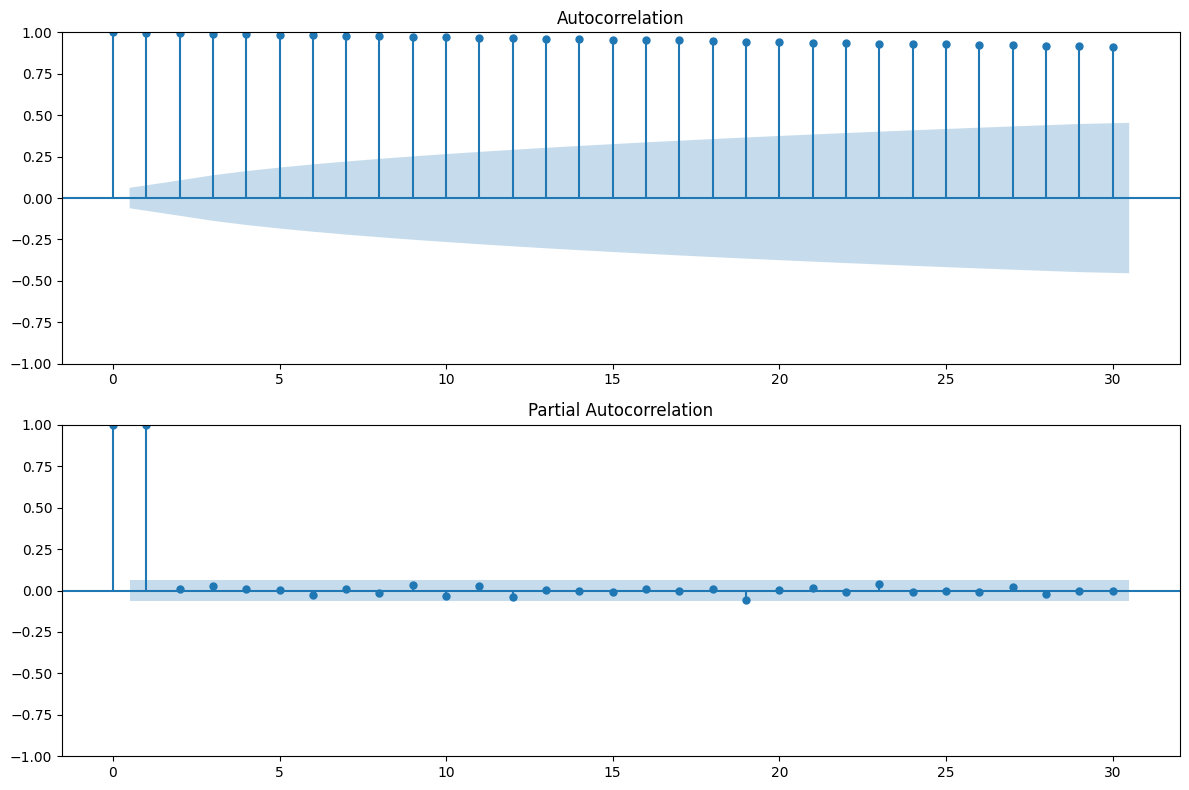

In [37]:
# 수정 종가에 대한 ACF 및 PACF 그래프 출력
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# ACF 그래프
plot_acf(df['Adj Close'].dropna(), ax=ax[0], lags=30)
ax[0].set_title('Autocorrelation')

# PACF 그래프
plot_pacf(df['Adj Close'].dropna(), ax=ax[1], lags=30)
ax[1].set_title('Partial Autocorrelation')

plt.tight_layout()
plt.show()

2.6 결과를 해석하세요.

1. ACF  
x축은 lag, y축은 correlation.  
0일 때는 자기 자신과의 관계기 때문에 당연히 1이 나온다.  
x축 부분을 보면 파란색 범위가 보인다. 저 범위를 벗어나 있으면 Autocorrelation이 있다고 판단하고(use_vlines=True) 내부에 있다면 Autocorrelation이 없다고 판단한다)  
막대가 파란색 상자 안에 들어가게 되면 통계적으로 값이 유의하지 않음
2. PACF  
x와 y축 값은 ACF와 동일함  
파란색 상자 안에 막대가 들어가게 되면서부터 값이 유의하지 않음  

=> 위 결과에서 ACF Plot은 점점 작아지고, PACF Plot은 첫 값으로부터 1(=p)개 뒤에 끊기기 때문에, 이 데이터셋을 사용할 때에는 AR(1) 모델을 활용하는 것이 가장 정확도가 높을 것
https://noelee.tistory.com/190 참고

2.7 마지막으로 계절성이 있는지 여부를 확인하겠습니다. statsmodels의 seasonal_decompose 라이브러리를 import하고 plot을 출력하세요.

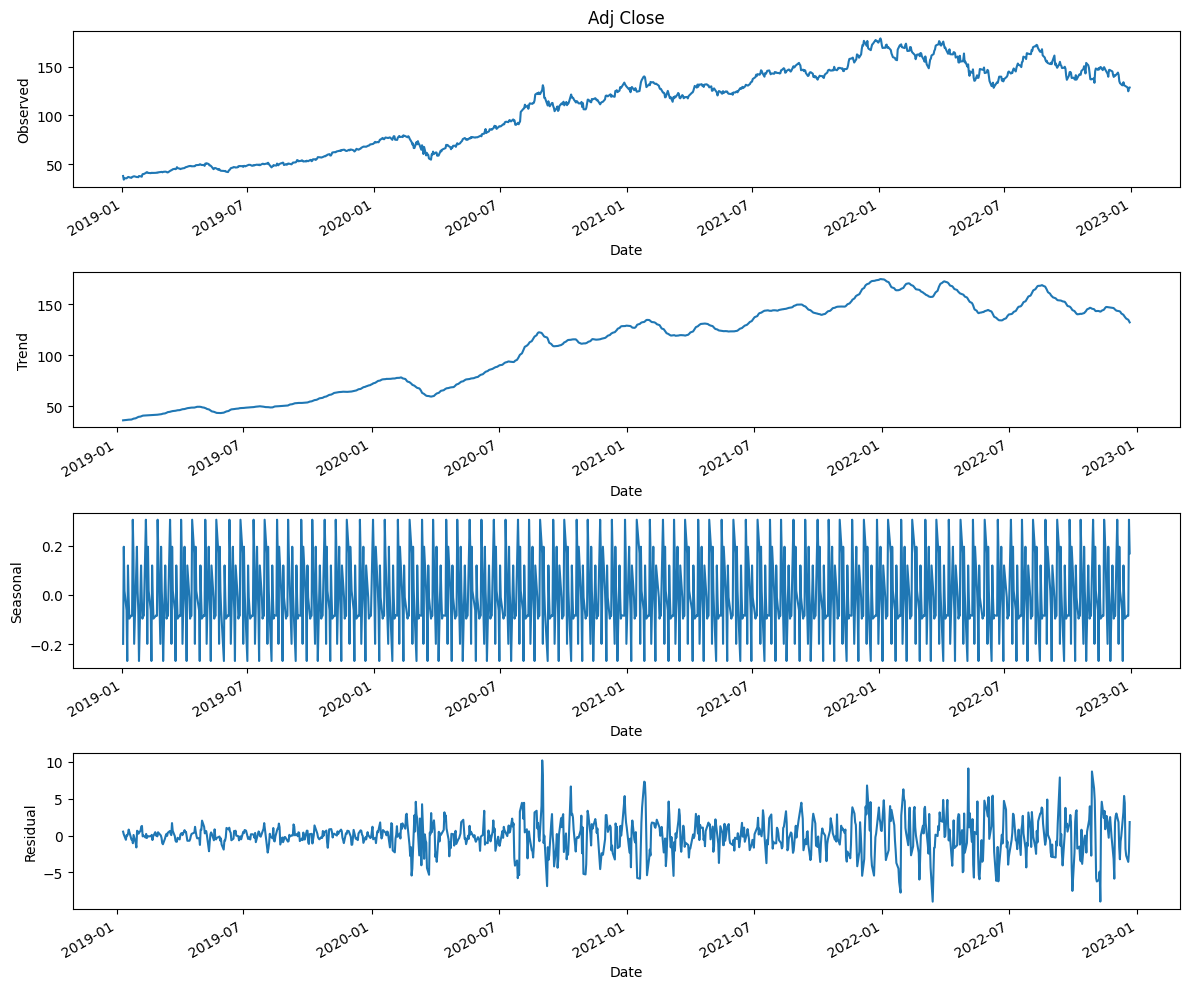

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 수정 종가를 시계열로 변환
df['Adj Close'] = df['Adj Close'].astype(float)

# 시계열 데이터 분해
result = seasonal_decompose(df['Adj Close'], model='additive', period=12)

# 결과 출력
fig, ax = plt.subplots(4, 1, figsize=(12, 10))

#원본 시계열 데이터
result.observed.plot(ax=ax[0], legend=False)
ax[0].set_ylabel('Observed')
ax[0].set_title('Adj Close')

#시간에 따른 장기적인 경항을 나타냄
result.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('Trend')

#정기적인 패턴이나 계절성을 나타냄, 일정 주기마다 반복되는 성분을 보여줌
result.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('Seasonal')

# 잔차 성분, 추세와 계절성을 제거한 후 남은 데이터, 이값은 노이즈를 포함하고 있으며 예측에 있어 불확실성을 나타냄
result.resid.plot(ax=ax[3], legend=False)
ax[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

2.8 위 결과를 해석하세요.

1. Trend : 점진적으로 증가
2. Seasonal : 특정패턴 반복
3. Residual : 

2.9 위에서 진행한 검정 과정 및 시각화 결과를 종합해봤을 때 현 데이터는 비정상성임을 알 수 있습니다. 따라서 차분을 통해 이를 해결하도록 하겠습니다. 먼저 차분이 어떤 것인지에 대해 설명하세요.

차분은 시계열 데이터를 정상성 상태로 변환하기 위한 방법 중 하나이다.

2.10 1차 차분을 진행하도록 하겠습니다. diff() 함수를 활용해 1차 차분을 진행한 후 ADF Test를 수행하여 정상성 여부를 확인하세요.

In [40]:
df['Adj Close Diff'] = df['Adj Close'].diff()

# ADF Test 수행
adf_result = adfuller(df['Adj Close Diff'].dropna())

adf_statistic = adf_result[0]
p_value = adf_result[1]
critical_values = adf_result[4]

print(f"ADF Statistic: {adf_statistic}")
print(f"p-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value}")

ADF Statistic: -33.7433441921963
p-value: 0.0
Critical Values:
   1%: -3.436866962597422
   5%: -2.864417284603703
   10%: -2.5683020002450507


2.11 추가로 위에서 그려보았던 plot들을 다시 그려보면서 비교를 통해 정상성 여부를 확인해보도록 하겠습니다. ACF PACF plot, 계절성 분해 plot을 그려보세요.

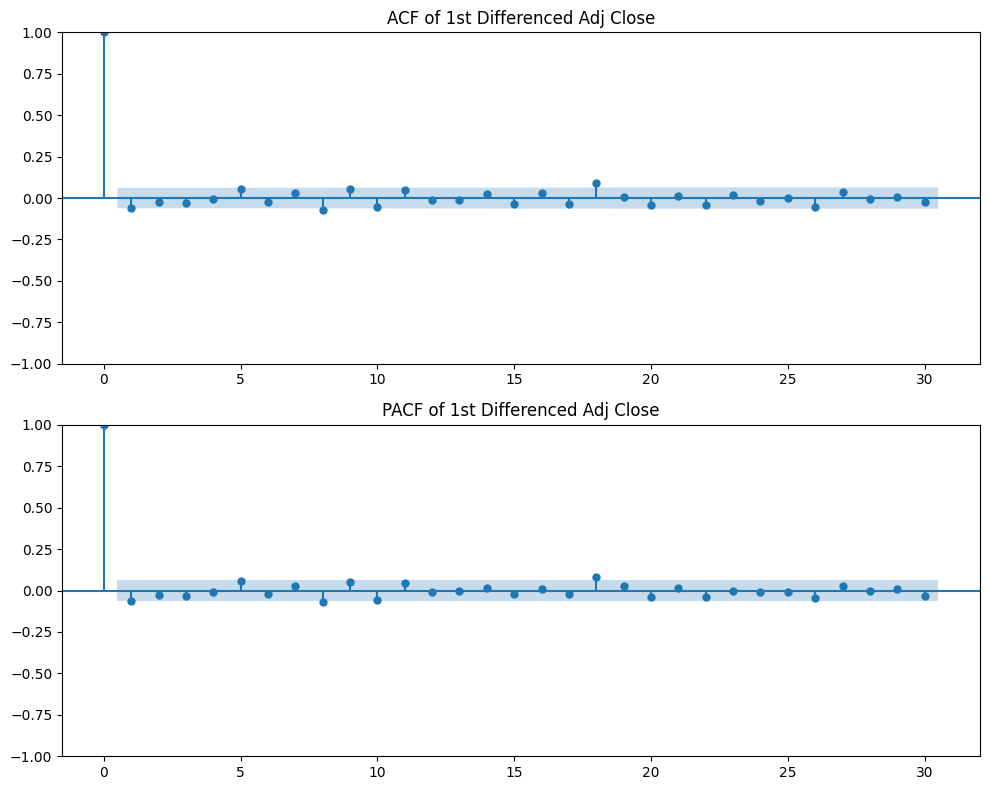

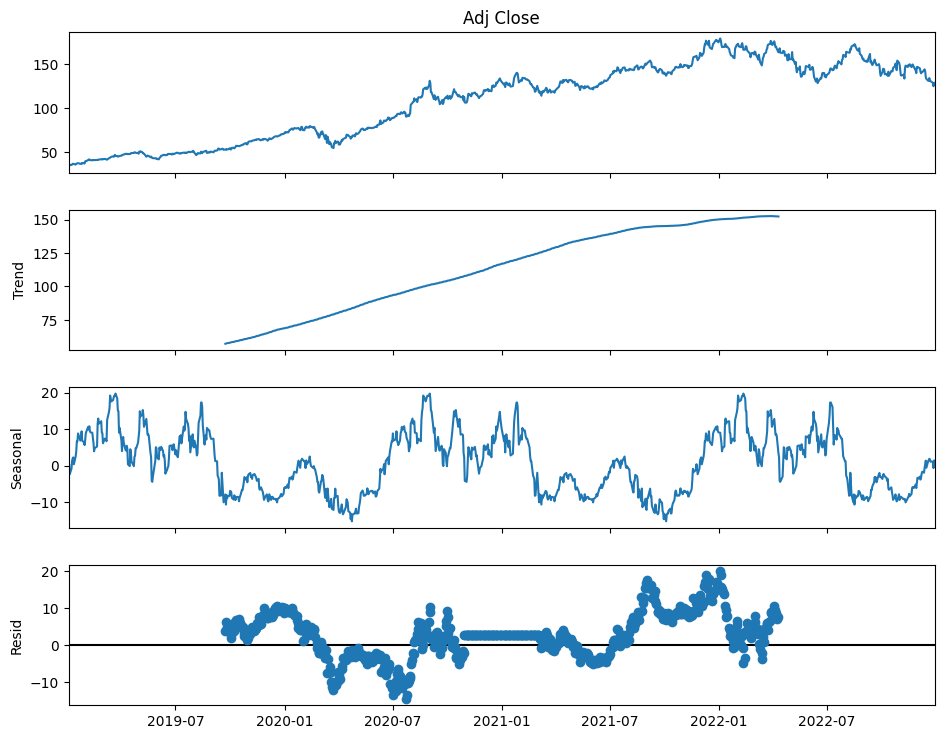

In [42]:
# ACF 및 PACF 플롯
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df['Adj Close Diff'].dropna(), ax=axes[0], lags=30)
axes[0].set_title('ACF of 1st Differenced Adj Close')
plot_pacf(df['Adj Close Diff'].dropna(), ax=axes[1], lags=30)
axes[1].set_title('PACF of 1st Differenced Adj Close')
plt.tight_layout()
plt.show()

# 계절성 분해
decomposition = seasonal_decompose(df['Adj Close'], model='additive', period=365)
decomposition.observed.index = df.index
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.show()

### 3. 예측

3.1 데이터의 정상성을 확인했으니 본격적으로 예측 및 분석을 진행해보도록 하겠습니다.

아래 코드는 예시이므로 예시에서 사용된 모델이 아닌 다른 모델(ex. ARIMAX, ARCH/GARCH, LSTM, Transformer, DLinear etc.)를 사용하고 애플이 아닌 다른 주식을 사용해 예측 및 분석을 진행해주세요(**위에서 진행한 과정 역시 모두 예시이므로 새로운 주식에 대한 전처리 및 정상성 검정을 새로 진행해야 함**).

In [43]:
from statsmodels.tsa.arima.model import ARIMA

In [52]:
ticker = 'MSFT'
df = yf.download(ticker, start='2020-01-01', end='2023-01-01')
sp500_data = yf.download('^GSPC', start="2021-01-01", end="2024-01-01")['Adj Close']
df['S&P 500'] = sp500_data
df = df.dropna()

df['Adj Close Diff'] = df['Adj Close'].diff().dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [53]:
df['Adj Close Diff']

Date
2021-01-04         NaN
2021-01-05    0.203384
2021-01-06   -5.472305
2021-01-07    5.850006
2021-01-08    1.288193
                ...   
2022-12-23    0.532364
2022-12-27   -1.744919
2022-12-28   -2.395569
2022-12-29    6.388138
2022-12-30   -1.173126
Name: Adj Close Diff, Length: 503, dtype: float64

In [55]:
# 종속 변수와 독립 변수를 각각 정렬 및 NaN 제거
endog = df['Adj Close Diff'].dropna()
exog = df['S&P 500'].loc[endog.index].dropna()

In [56]:
#  S&P 500 지수를 외부 변수로 사용
model = ARIMA(endog, order=(3, 0, 0), exog=exog)
model_fit = model.fit()

model_fit.summary()

/Users/hwangseojin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/hwangseojin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/hwangseojin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/hwangseojin/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Adj Close Diff   No. Observations:                  502
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -1497.695
Date:                Tue, 08 Oct 2024   AIC                           3007.390
Time:                        16:57:45   BIC                           3032.701
Sample:                             0   HQIC                          3017.320
                                - 502                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.4262      2.619     -1.308      0.191      -8.560       1.707
S&P 500        0.0008      0.001      1.321      0.187      -0.000       0.002
ar.L1         -0.0239      0.043     -0.554      0.579      -0.108       0.061
ar.L2         -0.0412      0.040     -1.041      0.298      -0.119       0.036
ar.L3         -0.0701      0.042     -1.669      0.095      -0.152       0.012
sigma2        22.8626      1.206     18.958      0.000      20.499      25.226
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                28.35
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               3.20   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/hwangseojin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


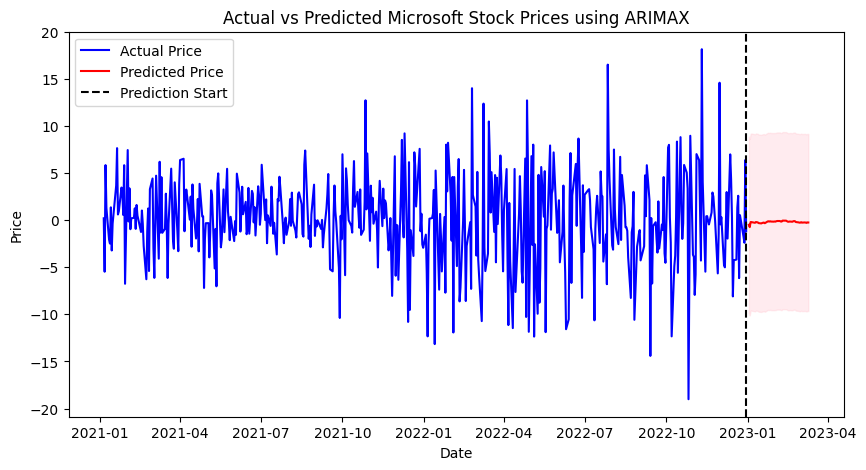

In [59]:
#예측 수행(50일, 200일해도 달라지지 않았음 ㅠ)
forecast_result = model_fit.get_forecast(steps=50, exog=exog[-50:])
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

#예측 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Adj Close Diff'], label='Actual Price', color='blue')
plt.plot(pd.date_range(start=df.index[-1], periods=51, freq='B')[1:], forecast, label='Predicted Price', color='red')
plt.fill_between(pd.date_range(start=df.index[-1], periods=51, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.axvline(x=df.index[-1], color='black', linestyle='--', label='Prediction Start')
plt.title('Actual vs Predicted Microsoft Stock Prices using ARIMAX')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [60]:
#실제 데이터 가져오기
actual_data_last_50 = yf.download(ticker, start='2024-01-01', end='2024-03-01')
actual_last_50 = actual_data_last_50[['Close']]


[*********************100%***********************]  1 of 1 completed


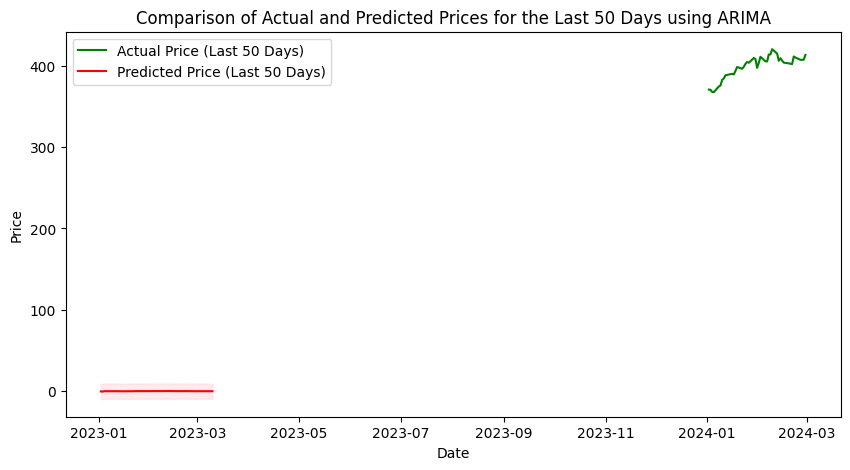

In [62]:
#실제 데이터와 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(actual_last_50.index, actual_last_50['Close'], label='Actual Price (Last 50 Days)', color='green')
plt.plot(pd.date_range(start=df.index[-1], periods=51, freq='B')[1:], forecast, label='Predicted Price (Last 50 Days)', color='red')
plt.fill_between(pd.date_range(start=df.index[-1], periods=51, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Comparison of Actual and Predicted Prices for the Last 50 Days using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### Prophet

Prophet 모델이란?
https://wikidocs.net/233162

In [64]:
!pip install prophet

  Obtaining dependency information for prophet from https://files.pythonhosted.org/packages/15/9a/a8d35652e869011a3bae9e0888f4c62157bf9067c9be15535602c73039dd/prophet-1.1.6-py3-none-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for cmdstanpy>=1.0.4 from https://files.pythonhosted.org/packages/5d/12/6522f3de83ca690aa52f4b8c88a1e203abb1e2d75c31669dc004949143cd/cmdstanpy-1.2.4-py3-none-any.whl.metadata
  Obtaining dependency information for holidays<1,>=0.25 from https://files.pythonhosted.org/packages/0f/69/fa78950f99c0add5222f693d13b987b642aa778bca63fb9aaaca365be16c/holidays-0.58-py3-none-any.whl.metadata
  Obtaining dependency information for importlib-resources from https://files.pythonhosted.org/packages/e1/6a/4604f9ae2fa62ef47b9de2fa5ad599589d28c9fd1d335f32759813dfa91e/importlib_resources-6.4.5-py3-none-any.whl.metadata
  Obtaining dependency information for stanio<2.0.0,>=0.4.0 from https://files.pythonhosted.org/packages/56/87/37a80e4d5bd453c33262d8fb618b6840fd

In [65]:
from prophet import Prophet

In [66]:
###Prophet의 경우 ARIMA와 검정 및 전처리 과정이 약간 달라 새로 진행하였으며 보다 정확한 추세 예측을 위해 200일까지 예측하였습니다.###


ticker = 'MSFT'
data = yf.download(ticker, start='2020-01-01', end='2023-01-01')

df = data.reset_index()[['Date', 'Close']]
df.columns = ['ds', 'y']  #Prophet에서는 날짜 컬럼을 'ds', 값 컬럼을 'y'로 설정해야 함

[*********************100%***********************]  1 of 1 completed


In [67]:
#모델 설정(파라미터는 따로 설정하지 않고 진행했으나 보다 정확한 예측을 위해 수정하는 것도 좋음)
model = Prophet()
model.fit(df)

17:03:54 - cmdstanpy - INFO - Chain [1] start processing
17:03:55 - cmdstanpy - INFO - Chain [1] done processing


In [68]:
#200일간의 예측 진행
future = model.make_future_dataframe(periods=200)
forecast = model.predict(future)

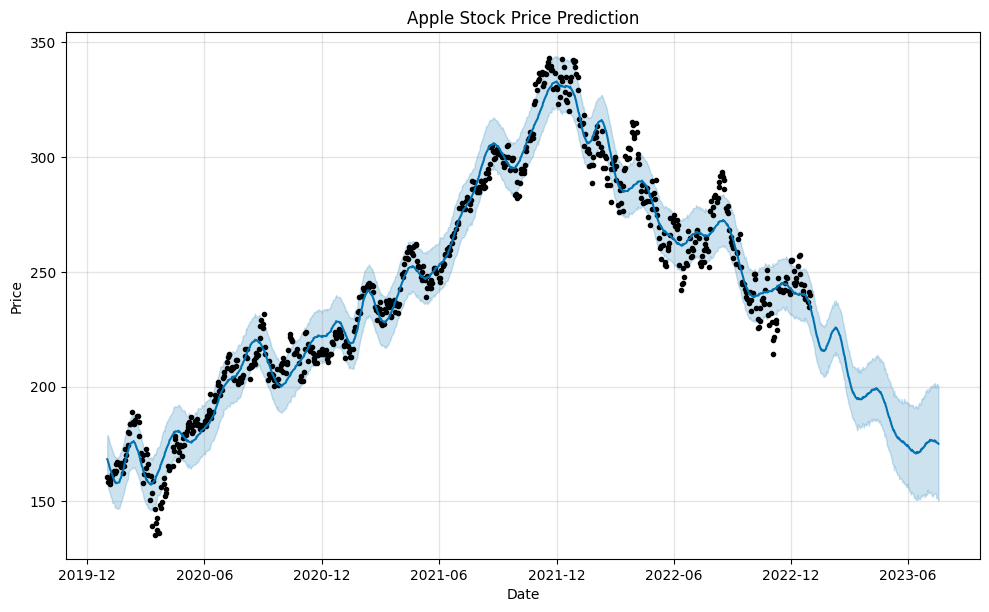

In [69]:
# 예측 결과 시각화
fig1 = model.plot(forecast)
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

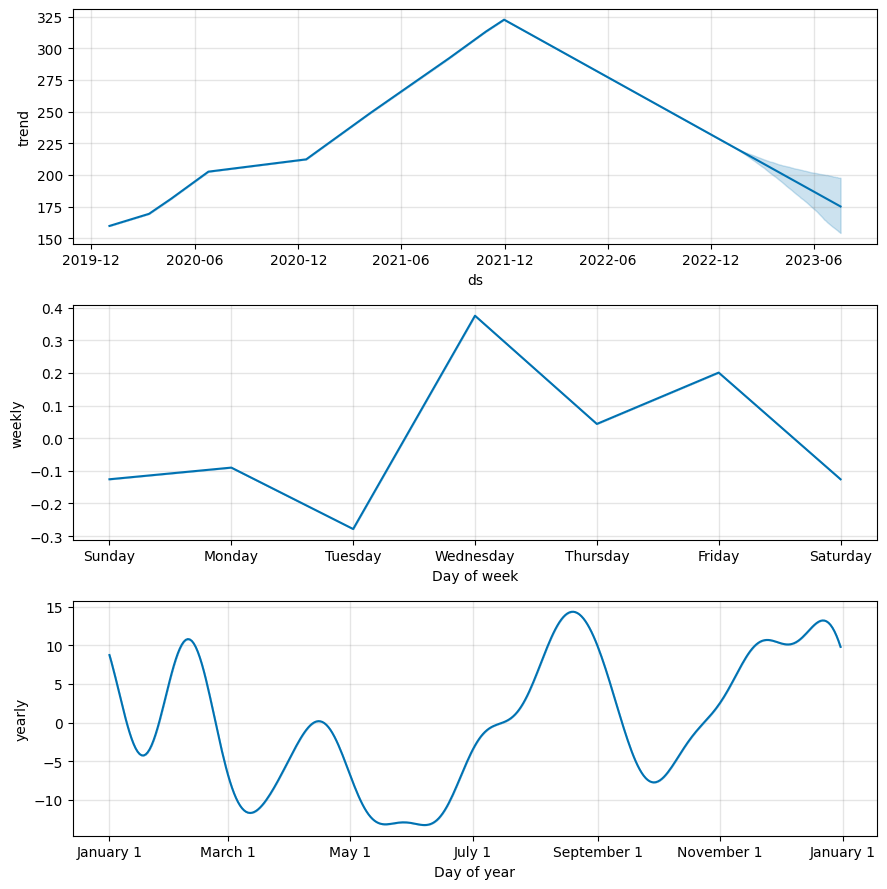

In [70]:
#트렌드 및 주기성 시각화
fig2 = model.plot_components(forecast)
plt.show()

In [71]:
#마지막 200일의 실제 주가 데이터 가져오기
actual_data_last_50 = yf.download(ticker, start='2024-01-01', end='2024-08-01')
actual_last_50 = actual_data_last_50.reset_index()[['Date', 'Close']]
actual_last_50.columns = ['ds', 'y']

[*********************100%***********************]  1 of 1 completed


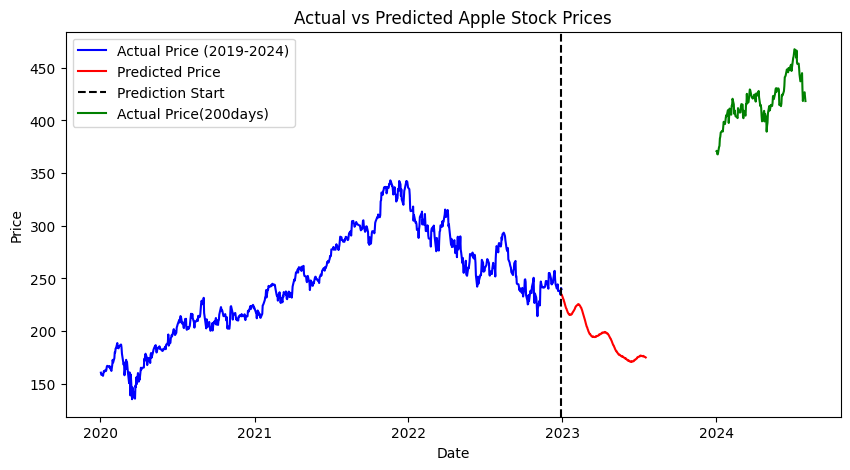

In [72]:
#실제 값과 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y'], label='Actual Price (2019-2024)', color='blue')

plt.plot(forecast['ds'][len(df):], forecast['yhat'][len(df):], label='Predicted Price', color='red') ##전체 예측값 중 200일 이후 것만 사용
plt.axvline(x=df['ds'].iloc[-1], color='black', linestyle='--', label='Prediction Start')
plt.plot(actual_last_50['ds'], actual_last_50['y'], label='Actual Price(200days)', color='green')
plt.title('Actual vs Predicted Apple Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


예시에서는 전통적 시계열 모형인 ARIMA 보다 최신 기법인 Prophet이 보다 좋은 성능을 보였습니다. 

사실 ARIMA로도 좋은 예측을 진행할 수는 있으나 조금 간단하게 진행하였으며(죄송합니다..시간관계상 ㅠ) SARIMA, ARIMAX와 같이 발전된 모형을 사용하는 것도 방법입니다. 

예시보다 좋은 예측을 진행하여 주시길 바라며 단순히 시각화하는 것을 넘어서 ***RMSE***나 ***MAE***와 같은 성능지표를 활용해 정량적 평가를 진행해주시면 좋을 것 같습니다.